# Load Library & Preprocess Data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import posenet

from config import *
from Datagenerator.Dataloader import load_data
from Datagenerator.Datagenerator import *
from Utils.draw_utils import *
from Utils.evaluate import evaluate
from Decode.decode_utils import *
from Decode.Decoder import *

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Load Data 

In [3]:
df = load_data()
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Inference 

In [5]:
with tf.device('/device:GPU:1'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inf_model.load_weights(f'./checkpoints/{ckpt_path}.hdf5')

In [6]:
# decode_model = add_decoder(inf_model)

In [7]:
inf_gen = EvalDataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

In [8]:
img, regr = inf_gen.__getitem__(11)
result = inf_model(img)
idx = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


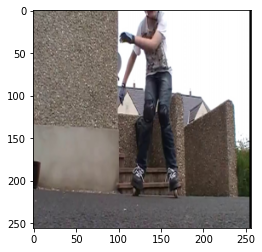

In [9]:
plt.imshow(img[idx])
plt.show()

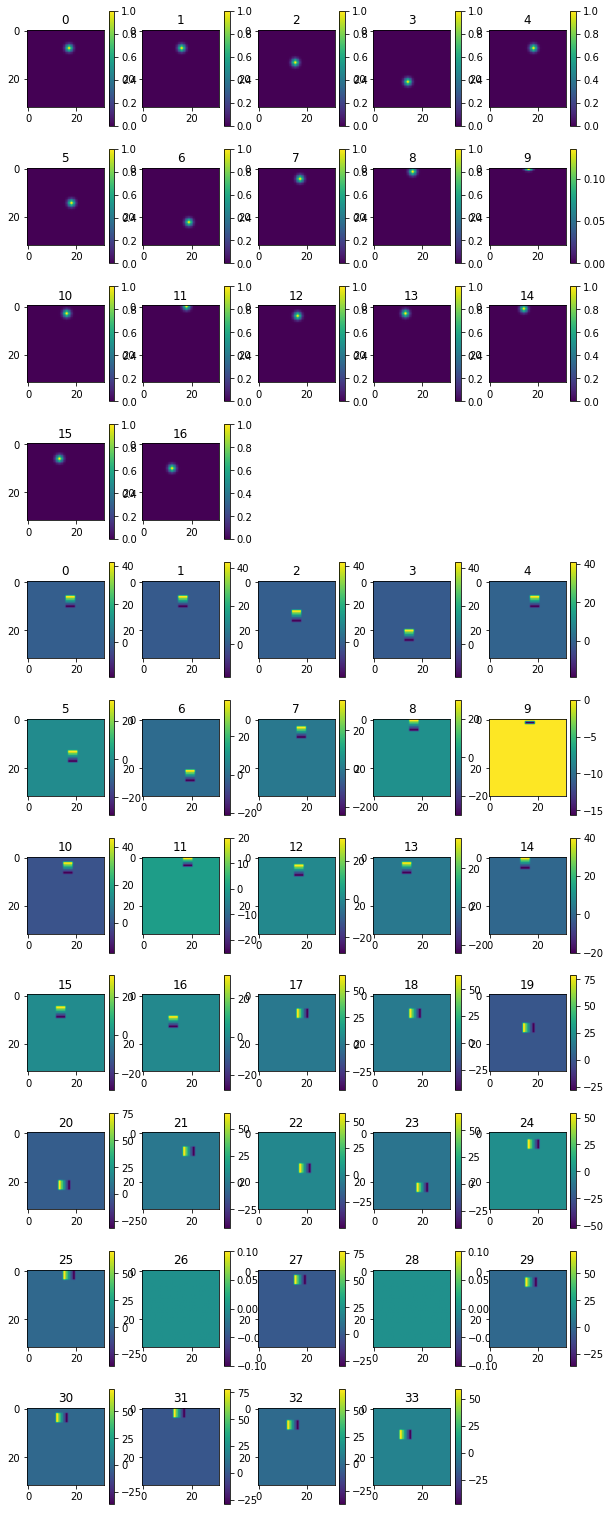

In [10]:
draw_heatmap(0, *regr)

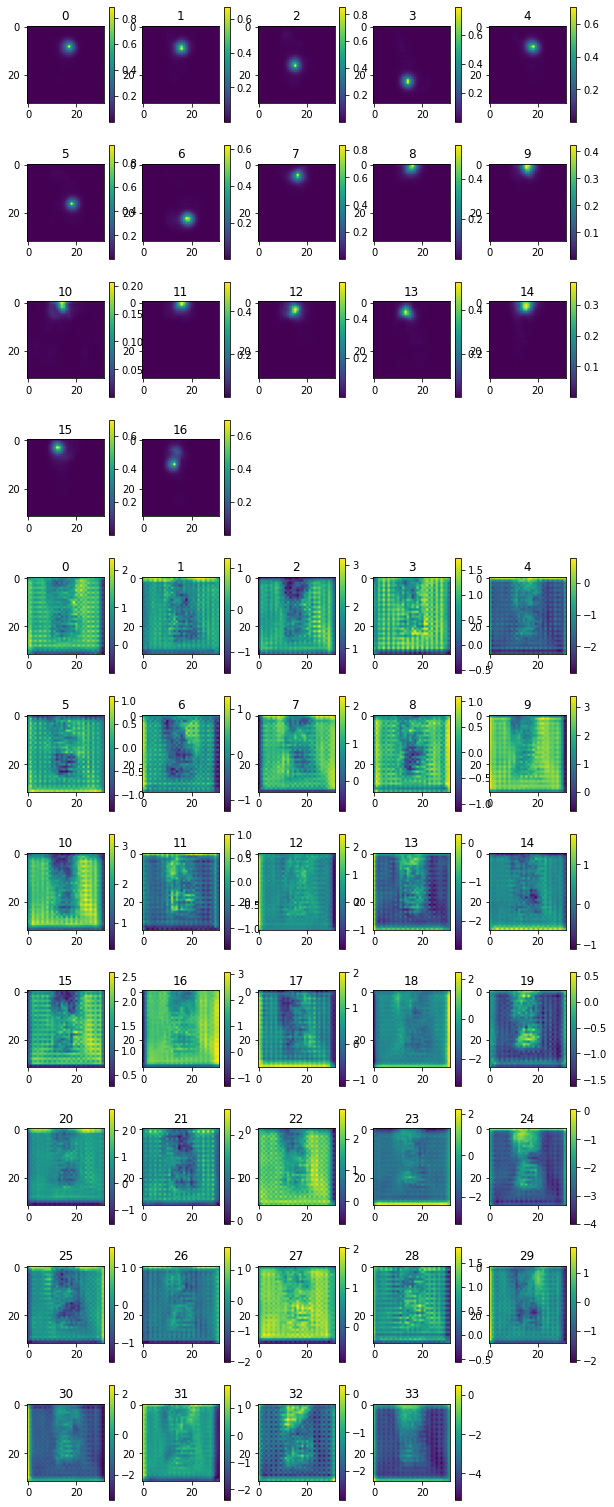

In [11]:
draw_heatmap(0, heatmap_result=result[0], offset_result=result[1])

# Decode

In [12]:
pose_scores, keypoint_scores, keypoint_coords = decode_single_poses(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score : {pose_scores}')
print(f'keypoint scores :')
print(f'{keypoint_scores}')
print(f'keypoint coords :')
print(f'{keypoint_coords}')

pose score : [0.5834080471712]
keypoint scores :
[0.88809395 0.66914332 0.8547979  0.79613334 0.70629686 0.94486493
 0.62412268 0.83862448 0.5675779  0.         0.         0.5335834
 0.58477312 0.52610195 0.         0.6926077  0.69121528]
keypoint coords :
[[ 64.92972374 136.92972374]
 [ 71.45641214 127.45641214]
 [129.34633005 121.34633005]
 [185.03295803 113.03295803]
 [ 62.35412455 142.35412455]
 [127.33014023 143.33014023]
 [175.80865939 143.80865939]
 [ 32.59660554 128.59660554]
 [ -0.5019123  127.4980877 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  7.55313209 127.55313209]
 [ 24.58082414 120.58082414]
 [ 31.40616709 103.40616709]
 [  0.           0.        ]
 [ 24.60265815  96.60265815]
 [ 81.10721254 105.10721254]]


In [13]:
pose_scores_nooff, keypoint_scores_nooff, keypoint_coords_nooff = decode_single_poses_nooff(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score nooff: {pose_scores_nooff}')
print(f'keypoint scores nooff:')
print(f'{keypoint_scores_nooff}')
print(f'keypoint coords nooff:')
print(f'{keypoint_coords_nooff}')

pose score nooff: [0.5834080471712]
keypoint scores nooff:
[0.88809395 0.66914332 0.8547979  0.79613334 0.70629686 0.94486493
 0.62412268 0.83862448 0.5675779  0.         0.         0.5335834
 0.58477312 0.52610195 0.         0.6926077  0.69121528]
keypoint coords nooff:
[[ 64. 136.]
 [ 72. 128.]
 [128. 120.]
 [184. 112.]
 [ 64. 144.]
 [128. 144.]
 [176. 144.]
 [ 32. 128.]
 [  0. 128.]
 [  0.   0.]
 [  0.   0.]
 [  8. 128.]
 [ 24. 120.]
 [ 32. 104.]
 [  0.   0.]
 [ 24.  96.]
 [ 80. 104.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


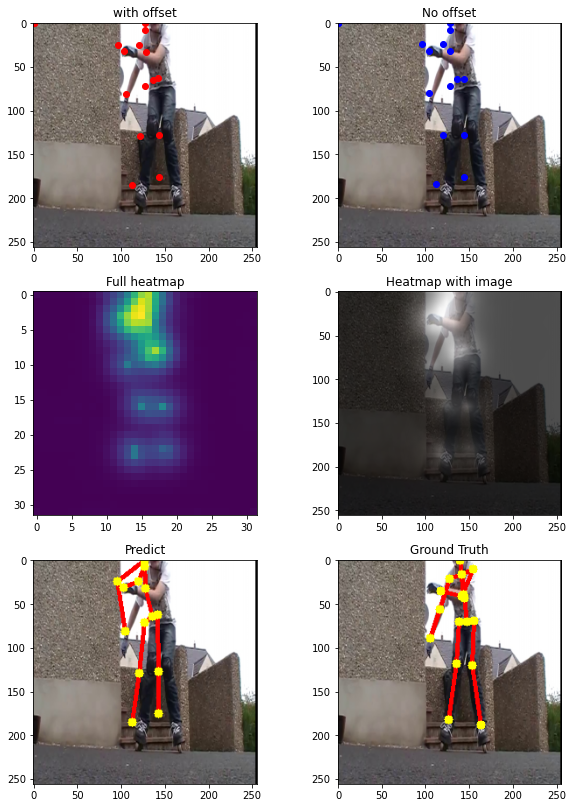

In [14]:
draw_result(img, idx, keypoint_coords, keypoint_coords_nooff, result, inf_gen)

# Evaluate 

In [15]:
evaluate(inf_model, inf_gen)

100%|██████████| 5045/5045 [03:58<00:00, 21.16it/s]

Total accuracy : 0.09351133912435453
